# Exercise 4
All previous instructions hold. In addition, if you are using GPU, you must check that your code also runs on a CPU. 

**Make sure you use the best practices you learned in class**.

In this exercise, you will accomplish the following:
1. Train a Localization as Regression network using a pre-trained model.
2. Build and train a recurrent neural network that will generate text.

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.patches as patches
import torchvision.models as models
from PIL import Image
import collections
import time
import copy
import sys
import os
from torch.utils.data import Dataset
import os 
import sys
import torch
from PIL import Image
import collections
if sys.version_info[0] == 2:
    import xml.etree.cElementTree as ET
else:
    import xml.etree.ElementTree as ET
    
import os 
import glob 
import torch
import random
import string
import unicodedata
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import time
import math

from io import open
import torch.nn as nn
import torch.optim as optim


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [3]:
print(f"Device is {device}")

Device is cuda


# Localization as Regression (60 points)

State of the art accuracy on CIFAR10 is currently ~99% on the test set. In the next part, we will use a well known architecture called ResNet18 that was trained on ImageNet, a dataset far more rich than CIFAR10. ImageNet has 1,000 classes and 1,000,000 images and the pretrained ResNet18 available in PyTorch correctly classifies ~70% of the test set. In this part, we will use the features extracted from ResNet18 to localize and classify images of cats and dogs. 

Using a pretrained network as a building block for a more complicated task is at the heart of neural networks today. By leveraging the features ResNet18 extracts, we can train a model that can correctly classify and localize cats and dogs using very few images.

Download the data from: "https://drive.google.com/file/d/14O0bM_h5OtYn5IJKZoFUe1bCF6N-h1Wb/view?usp=sharing".

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# use the data that was given to you with the assignment
!unzip data.zip

In [8]:
class VOCDetection(Dataset):
    def __init__(self,
                 root,
                 image_set='trainval',
                 transform=None,
                 target_transform=None):
        self.root = os.path.expanduser(root)
        self.transform = transform
        self.target_transform = target_transform
        self.image_set = image_set
        self.classes = ['cat', 'dog']
        
        image_dir = os.path.join(self.root, 'images')
        annotation_dir = os.path.join(self.root, 'annotations')
    
        split_f = os.path.join(self.root, image_set.rstrip('\n') + '.txt')
        with open(os.path.join(split_f), "r") as f:
            file_names = [x.strip().split(' ')[0] for x in f.readlines()]
        self.images = [os.path.join(image_dir, x + ".jpg") for x in file_names]
        self.annotations = [os.path.join(annotation_dir, x + ".xml") for x in file_names]
        assert (len(self.images) == len(self.annotations))

    def __getitem__(self, index):
        img = Image.open(self.images[index]).convert('RGB')
        label, bbox = False, False
        if(self.annotations):
            target = self.parse_voc_xml(ET.parse(self.annotations[index]).getroot())
            label = target['annotation']['object']['name']
            if label == 'dog':
                label = 1
            else:
                label = 0
            x1, y1, x2, y2 = target['annotation']['object']['bndbox'].values()
            x1 = int(x1)
            y1 = int(y1)
            x2 = int(x2)
            y2 = int(y2)
            bbox = np.array([x1, y1,x2, y2])
        sample = {'image':img, 'label':label, 'bbox':bbox}
        if self.transform is not None:
            sample = self.transform(sample)
        return sample

    def __len__(self):
        return len(self.images)

    def parse_voc_xml(self, node):
        voc_dict = {}
        children = list(node)
        if children:
            def_dic = collections.defaultdict(list)
            for dc in map(self.parse_voc_xml, children):
                for ind, v in dc.items():
                    def_dic[ind].append(v)
            voc_dict = {
                node.tag:
                {ind: v[0] if len(v) == 1 else v
                 for ind, v in def_dic.items()}
            }
        if node.text:
            text = node.text.strip()
            if not children:
                voc_dict[node.tag] = text
        return voc_dict


class ToTensor(object):
    def __call__(self, sample):
        pic = sample['image']
        sample['image'] = F.to_tensor(pic)
        return sample

    def __repr__(self):
        return self.__class__.__name__ + '()'
        
class Rescale(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, label, bbox = sample['image'], sample['label'], sample['bbox']
        h, w = image.size[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size
        new_h, new_w = int(new_h), int(new_w)
        img = F.resize(image, (new_h, new_w))
        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        bbox = bbox * [new_h / h, new_w / w, new_h / h, new_w / w]
        bbox = bbox / 224
        bbox = torch.tensor(bbox, dtype=torch.float32)
        return {'image':img, 'label':label, 'bbox':bbox}

class Normalize(object):
    def __init__(self, mean, std, inplace=False):
        self.mean = mean
        self.std = std
        self.inplace = inplace

    def __call__(self, sample):
        img = sample['image']
        sample['image'] = F.normalize(img, self.mean, self.std)
        return sample

def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou

To load ResNet18 with the pretrained weights, use the following line. You are welcome to try different architectures, however they might require different input sizes or normalization.

The first time you run this cell the weights will be downloaded.

In [9]:
resnet18 = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet takes as input images of size (224,224). We will use PyTorch Transforms to change the size of the images. When ResNet18 was trained on ImageNet, the images were normalized using the mean and standard deviation of the images. In order to properly use the weights, we will use the same normalization.

In [10]:
data_transforms = {
    'train': transforms.Compose([
        Rescale((224,224)),
        ToTensor(),
        Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalizing according to imagenet
    ]),
    'val': transforms.Compose([
        Rescale((224,224)),
        ToTensor(),
        Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
# root_dir = "/content/animals/"
root_dir = "/content/drive/MyDrive/data/animals/"
datasets = {x: VOCDetection(root_dir, image_set=x, transform=data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=32, shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}
classes = datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(dataset_sizes)

{'train': 636, 'val': 158}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [11]:
# Get a batch of training data
sample = next(iter(dataloaders['train']))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


<Figure size 864x576 with 0 Axes>

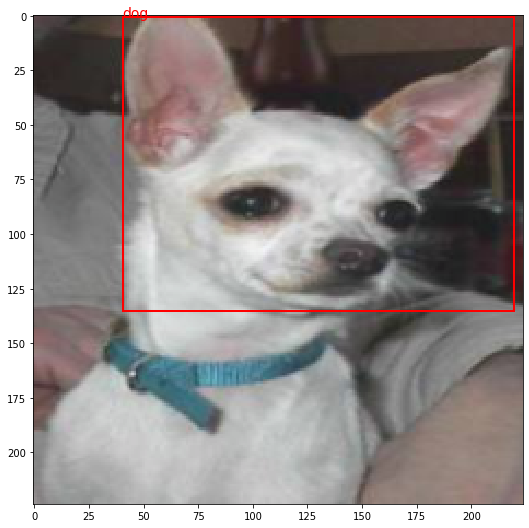

In [12]:
def imshow(img, label, bbox):
    image = np.copy(img[0])
    image = np.transpose(image, (1, 2, 0))
    image *= np.array([0.229, 0.224, 0.225])
    image += np.array([0.485, 0.456, 0.406])
    label = label[0]
    bbox = bbox[0]
    plt.figure();
    fig, ax = plt.subplots(1, figsize=(12,9));
    ax.imshow(image);
    x1, y1, x2, y2 = bbox.numpy().reshape(-1) * 224
    box_w, box_h = np.abs(x2-x1), np.abs(y2-y1)
    bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, 
                             edgecolor='r', facecolor='none');
    ax.add_patch(bbox);
    ax.annotate(classes[label], (x1, y1), color='r', fontsize=14);

imshow(sample['image'],sample['label'],sample['bbox'])

In [18]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        #############################################################################
        # TO DO:                                                                    #
        # Load the pretrained ResNet-18 network and replace the top fully           #
        # connected layer, so we could pass the features of the convolutional       #
        # network and not only the classification layer which carries significantly #
        # less information.                                                         #
        # Afterwards, create a new sequential model which includes the resnet and   #
        # add a new fully connected layer that outputs a vector with the size of    #
        # the wanted dimensionality.                                                #
        # This function has no return value.                                        #
        #############################################################################
        
        for param in resnet18.parameters():
            param.requires_grad = False

        self.num_features = resnet18.fc.in_features 
        layers_list = list(resnet18.children())
        self.resnet_layers = nn.Sequential(*layers_list[:-1]).to(device)

        self.fc = nn.Sequential(
            nn.Dropout(),
            nn.Linear(self.num_features, 4096), 
            nn.BatchNorm1d(4096),
            nn.ReLU(True),
            nn.Linear(4096, 4096), 
            nn.BatchNorm1d(4096),
            nn.ReLU(True)
        ).to(device)

        self.classifier_layer = nn.Sequential(
            nn.Linear(4096, num_classes), 
            nn.ReLU(True)
        )

        self.bbox_layer = nn.Sequential(
            nn.Linear(4096, 1024), 
            nn.BatchNorm1d(1024),
            nn.ReLU(True),
            nn.Linear(1024, 4),
            nn.Sigmoid()
        ).to(device)

        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################
    
    def forward(self, images):
        #############################################################################
        # TO DO:                                                                    #
        # Define the forward propagation. You need to pass an image through the     #
        # network and extract the feature vector. In this case, when using a        #
        # pre-defined network, you don't want to change it's weights.                #
        # The rest of the layers you defined should accepts gradients for them to   #
        # improve during training.                                                  #
        # This function returns a class predication and a bounding box.             #
        #############################################################################

        images = images.to(device)
        outputs = self.resnet_layers(images)
        
        outputs = outputs.view(outputs.shape[0], -1)  # flatten
        outputs = self.fc(outputs)
        
        bbox_pred = self.bbox_layer(outputs)
        class_pred = self.classifier_layer(outputs)
        
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################
        return class_pred, bbox_pred

## Guidelines

1. Complete the `train_model` function in the cell below. This function takes as input the model and additional hyper-parameters, and outputs the best model found on the validation set. 
2. To babysit the learning process, **you must track the classification accuracy, IoU score and loss on the training and validation datasets and visualize them** (using tensorboard or matplotlib). I have included an implementation of the IoU metric in the notebook.
3. Do not perform a massive grid search. Use papers, blogs, MOOCs and online guides to research best hyper-parameters for your model. Once you chose your model. Explain why you chose that architecture and why you think it performs better than other networks you tried - use citation from sources you used.
4. You are encouraged to try Google Colab or a free AWS / Google Cloud Platform / Azure available for students. If you have an CUDA capable GPU at home - you are welcome to use it. Training one of our networks on a Core i7 for 10 epochs took 5 minutes and reached 99% classification accuracy and over 0.75 IoU score on the validation set (this took less than a minute using a RTX 2080 Ti GPU).
5. **Include only your chosen architecture**. During experimentation, you may add as many cells as you need. Make sure to delete them before submission.
6. Training large neural networks may take a while. Make sure your code runs reasonably fast (~30 minutes on CPU and ~5 minutes on GPU).
7. **In order to get full marks for this section, reach at least 98% classification accuracy and a IOU score of at least 0.70 on the validation set using a single model, explain the results and include visualizations**.
8. You are given a general skeleton for the training function. Feel free to use any different structure.

In [19]:
def train_model(model, criterion_cls, criterion_bbox, optimizer, scheduler=None, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict()) # this is how a model is copied
    best_acc = 0.0

    dic_history_metrics = {}
    dic_history_metrics['train'] = {}
    dic_history_metrics['train']['loss_history'] = []
    dic_history_metrics['train']['accuracy_history'] = []
    dic_history_metrics['train']['iou_history'] = []
    
    dic_history_metrics['val'] = {}
    dic_history_metrics['val']['loss_history'] = []
    dic_history_metrics['val']['accuracy_history'] = []
    dic_history_metrics['val']['iou_history'] = []

    for epoch in range(num_epochs):
    
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0   # total loss of the network at each epoch
            running_corrects = 0 # number of correct predictions
            iou = 0.0            # IoU score
            
            # Iterate over data.
            for sample in dataloaders[phase]:
                #############################################################################
                # TO DO:                                                                    #
                # Extract the data from the dataloader, calculate the predictions of your   #
                # network and calculate the loss of the classification and bounding box     #
                # prediction. When in training mode, back-prop and update the weights.      #
                # At each epoch, calculate the test and train accuracy and IoU.             #
                # This function returns the best model in terms of accuracy.                #
                #############################################################################
            
                inputs = sample['image'].to(device)
                labels = sample['label'].to(device)
                bbox = sample['bbox'].to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # we track history only when training
                with torch.set_grad_enabled(phase == 'train'):
                              
                    # Forward
                    label_pred, bbox_pred = model(inputs)
                    label_pred = label_pred.to(device)
                    bbox_pred = bbox_pred.to(device)

                    # Labeling Prediction
                    _, label_actual_preds = torch.max(label_pred, 1)
                    loss_labels = criterion_cls(label_pred, labels)
                    
                    # Bounding Boxes Prediction
                    loss_bbox = criterion_bbox(bbox_pred, bbox)
                    combined_loss = loss_labels + loss_bbox
                    
                    # IOU 
                    for box_i in range(len(bbox)):
                      iou += bb_intersection_over_union(bbox[box_i], bbox_pred[box_i])
                    
                    # Backward: Optimize only in training phase
                    if phase == 'train':
                        combined_loss.backward()
                        optimizer.step()

                # statistics
                running_loss += combined_loss.item() * inputs.size(0)
                running_corrects += torch.sum(label_actual_preds == labels.data)
                #############################################################################
                #                             END OF YOUR CODE                              #
                #############################################################################

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            iou = iou.item() / dataset_sizes[phase]

            dic_history_metrics[phase]['loss_history'].append(epoch_loss)
            dic_history_metrics[phase]['accuracy_history'].append(epoch_acc)
            dic_history_metrics[phase]['iou_history'].append(iou)
            
            print('{} Loss: {:.4f}  |  Acc: {:.4f}  |  IOU: {:.4f}'.format(
                phase, epoch_loss, epoch_acc, iou))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, dic_history_metrics

Choose your optimizer and the loss functions for the classification and bounding box regression.

In [20]:
cnn = CNN(2)
cnn = cnn.to(device)

criterion_cls = None
criterion_bbox = None
optimizer = None
#############################################################################
#                           START OF YOUR CODE                              #
#############################################################################
criterion_cls = nn.CrossEntropyLoss()
criterion_cls = criterion_cls.to(device)

criterion_bbox = nn.MSELoss()
criterion_bbox = criterion_bbox.to(device)

optimizer = optim.Adam(cnn.parameters(), lr=0.001)
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

In [21]:
best_model, dic_history_metrics = train_model(cnn, criterion_cls, criterion_bbox, optimizer, num_epochs=10)

Epoch 0/9
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.3807  |  Acc: 0.8522  |  IOU: 0.6494
val Loss: 0.2160  |  Acc: 0.9114  |  IOU: 0.6554
Epoch 1/9
----------
train Loss: 0.2074  |  Acc: 0.9434  |  IOU: 0.7232
val Loss: 0.0532  |  Acc: 0.9873  |  IOU: 0.7403
Epoch 2/9
----------
train Loss: 0.1616  |  Acc: 0.9387  |  IOU: 0.7349
val Loss: 0.0379  |  Acc: 0.9937  |  IOU: 0.7517
Epoch 3/9
----------
train Loss: 0.1110  |  Acc: 0.9607  |  IOU: 0.7419
val Loss: 0.0402  |  Acc: 0.9937  |  IOU: 0.7340
Epoch 4/9
----------
train Loss: 0.0880  |  Acc: 0.9717  |  IOU: 0.7439
val Loss: 0.0367  |  Acc: 0.9937  |  IOU: 0.7434
Epoch 5/9
----------
train Loss: 0.0768  |  Acc: 0.9780  |  IOU: 0.7423
val Loss: 0.0290  |  Acc: 0.9937  |  IOU: 0.7442
Epoch 6/9
----------
train Loss: 0.1021  |  Acc: 0.9686  |  IOU: 0.7410
val Loss: 0.0355  |  Acc: 0.9937  |  IOU: 0.7501
Epoch 7/9
----------
train Loss: 0.0677  |  Acc: 0.9811  |  IOU: 0.7475
val Loss: 0.0335  |  Acc: 0.9873  |  IOU: 0.7563
Epoch 8/9
----------
train Loss: 0.0870  |  Acc: 0.97

Once you are pleased with your results, see how your model can predict and localize cats and dogs!

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


<Figure size 864x576 with 0 Axes>

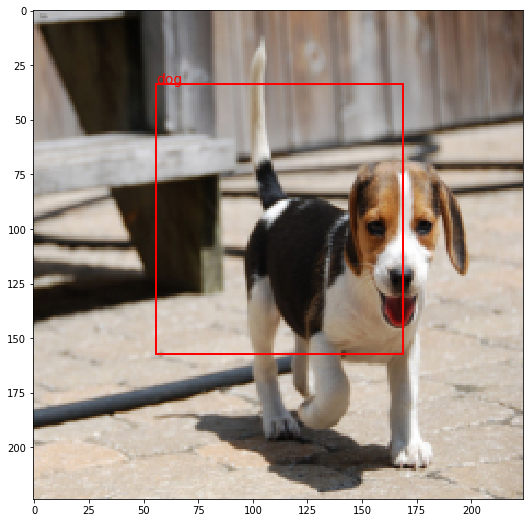

In [22]:
# Get a batch of validation data
sample = next(iter(dataloaders['val']))
with torch.no_grad():
    images = sample['image']
    images = images.to(device)
    label_pred, bbox_pred = best_model(images)
    _, label_pred = torch.max(label_pred, 1)
imshow(sample['image'], label_pred.cpu(), bbox_pred.cpu())

Your visualizations here (IoU / Accuracy / Loss on training and validation datasets as a function of the epoch). Only visualize the results of your best model.

[]

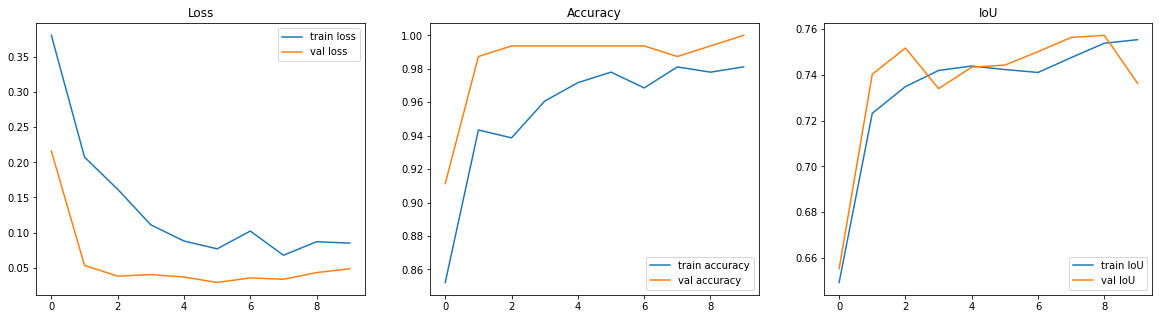

In [23]:
# Your visualization go into this cell
fig, ax = plt.subplots(1, 3)
num_epochs = 10

# Loss
ax[0].plot(np.arange(num_epochs), dic_history_metrics['train']['loss_history'], label='train loss')
ax[0].plot(np.arange(num_epochs), dic_history_metrics['val']['loss_history'], label='val loss')
ax[0].legend()
ax[0].set_title("Loss")

# Accuracy
ax[1].plot(np.arange(num_epochs), dic_history_metrics['train']['accuracy_history'], label='train accuracy')
ax[1].plot(np.arange(num_epochs), dic_history_metrics['val']['accuracy_history'], label='val accuracy')
ax[1].legend()
ax[1].set_title("Accuracy")

# IoU
ax[2].plot(np.arange(num_epochs), dic_history_metrics['train']['iou_history'], label='train IoU')
ax[2].plot(np.arange(num_epochs), dic_history_metrics['val']['iou_history'], label='val IoU')
ax[2].legend()
ax[2].set_title("IoU")

fig.set_size_inches(20, 5)
plt.plot()

The final architecture is as follows:

ResNet-18 (except the last layer) -> 
fc(resnet18.fc.in_features, 4096) -> batch norm + relu -> 
fc(4096, 4096) -> batch norm + relu -> 



- -> fc(4096, |classes|) for the class prediction
- -> fc(4096, 1024) +batch norm + relu -> fc(1024, 4) for the bounding box prediction + sigmoid

I've been experimenting with different architectural combinations. Below I elaborate on the process I went through and the insights regarding each variable.

The CNN part of the network is given by the ResNet-18 architecture (num of convolution layers, dimensions, pooling, stride, padding, and the filter size). When I enriched with two fc layers between the two subnetworks: one that classifies the image and one that predicts the bounding boxes.

**epochs:** 10 epochs were used as suggested.

**fc dimensions:** *My final fully connected layers has a dimension of 4 for the bbox and of num_classes for the labels. For the intermediate layers between the ResNet-18 architecture and the final fully-connected layers, I used 4096 dimensions, inspired by online examples and AlexNet architectures.

**dropout:** I used for the fc intermediate layers.

**loss function:** as learned in class, the loss is summed by the two problems: prediction and regression. Summed by the bounding box loss - MSEloss and the labels loss - cross-entropy loss.

**activation:** I chose the log_softmax activation over ReLu for the labels fully connected layer, and choose the sigmoid activation over the ReLu for the bounding box fully connected layer.

**optimizer:** I’ve initially tried SGD with 0.9 momentum as in the ResNet architecture, but eventually I chose to use the Adam optimizer which improved the performance.

The online references I've used in addition to class lectures:

- https://www.analyticsvidhya.com/blog/2019/10/how-to-master-transfer-learning-using-pytorch/

- https://www.udemy.com/course/pytorch-for-deep-learning-with-python-bootcamp/



**results:** we got validation accuracy of ~99% with IOU score of ~0.73. as we can see from the plots below, the loss is decreaing over-time as expected, while the IOU score and the Accuracy is increasing over-time, however, after the forth epoch it seems like my architecture has reached to some local (or global) optimum.


# Generating text using RNNs (40 points)

Using PyTorch, create a network that is capable of generating text, similar to the text it has seen during training. In order to tackle this problem, first read the [following blog post](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) by Andrej Karpathy for some creative uses of this network and his implementation of a [char-based RNN in pure numpy](https://gist.github.com/karpathy/d4dee566867f8291f086).

While implementing your own network (**in PyTorch**), make sure to consider the following:

1. We need to get a large enough text file, with proper encoding. You should use the creations of [Shakespere](https://ocw.mit.edu/ans7870/6/6.006/s08/lecturenotes/files/t8.shakespeare.txt).
2. Encode the text and map each character to an integer. One-hot encoding might also be a good idea.
3. You might be temped to use a dataloader, however defining your own method to obtain training batches might be easier.
4. Define your model. The following guide will help you understand how to use RNNs in PyTorch: [RNN text classification](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html). You model should be relatively simple.
5. Train your model. Training a proper model might take a while, so you are encouraged to use [Colab](https://colab.research.google.com/).
6. Create function that takes the learned network and predicts a single character. This function should take a hidden state and an input character, and output the next hidden state and the predicted character.
7. Finally, create a sampling function that takes the network, the required length of text to generate and an initial input and generate some text.

Online sources I've used:

- https://towardsdatascience.com/character-level-language-model-1439f5dd87fe 

- https://github.com/edumunozsala/Character-Level-Text-Generation/blob/master/char-level-text-generator-pytorch-SageMaker.ipynb

In [5]:
with open('/content/drive/MyDrive/data/t8.shakespeare.txt', 'r') as f:
    text = f.read()

In [ ]:
## Your code here. Add as many cells as you need ##

In [ ]:
generateTxet(model, 500, 't')

"then and theme one mowe tinges, have with she haned.\n HALE PO(MOLISG. Why lord I at I vore of theenffence the goo.\n CEMMACHIR MAMEST 199001990]\n\n\n\n<<<LECHIS MPHOSCERS. Where and be you hir more, I rat I geterd?\n BERSARS. Whore the proogscerthfeld. And eart my his, the rach try wime with upore than in the premetak vie, that tiling len in thel bhey to this bit whech the Camend; bet hade tisere'd thine reature we condented fas more that foil know hather of of at bof.\n But, IA\n Of that I hor tring to"

# Train RNN

In [37]:
import random
import re
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch


class CharsData:
    def __init__(self, text):
        self.text = text
        self.unique_letters = set(text)
        self.num_unique_letters = len(self.unique_letters)
        self.index_to_letter_mapping = {idx: letter for idx, letter in enumerate(self.unique_letters)}
        self.letter_to_index_mapping = {letter: idx for idx, letter in enumerate(self.unique_letters)}

    def process_text(self):
        import re
        text = self.text
        text = re.sub(' +', ' ', text)
        text = re.sub(' \n', ' ', text)
        self.text = text
        return self.text


def letter_idx_to_one_hot_vector(idx, chars_data):
    vector = np.zeros(chars_data.num_unique_letters)
    vector[idx] = 1
    return vector

def text_to_tensor(text, chars_data):
    vectors = np.zeros(shape=(len(text), chars_data.num_unique_letters), dtype=np.int)
    for i, char in enumerate(text):
        vectors[i] = letter_idx_to_one_hot_vector(chars_data.letter_to_index_mapping[char], chars_data)
    vectors = Variable(torch.from_numpy(vectors))
    return vectors

def letters_index_vector(text, chars_data):
    return torch.from_numpy(np.array([chars_data.letter_to_index_mapping[letter] for letter in text]))


class SampleBatch:
    def __init__(self, chars_data: CharsData):
        self.chars_data = chars_data
        self.training_text_input_len = 150
        self.letters = chars_data.unique_letters
        self.num_unique_letters = chars_data.num_unique_letters

    def generate_training_sample(self, text):
        text_len = len(text)
        start_i = np.random.randint(0, text_len - self.training_text_input_len)
        text_sample = text[start_i: (start_i + self.training_text_input_len + 1)]
        inputs_letters = text_to_tensor(text_sample[:-1], self.chars_data)
        target_letters = letters_index_vector(text_sample[1:], self.chars_data)
        return inputs_letters, target_letters


class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(RNNModel, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.rnn = nn.RNN(self.input_dim, self.hidden_dim, batch_first=True)
        self.out_layer = nn.Linear(hidden_dim, output_dim)

    def forward(self, input, hidden):
        outputs, hidden = self.rnn(input.view(1, 1, -1), hidden)
        outputs = self.out_layer(outputs.view(1, -1))
        return outputs, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.num_layers, 1, self.hidden_dim))

class TrainingParams:
    def __init__(self):
        self.num_iterations = 4000
        self.print_iteration = 150


class ModelParams:
    def __init__(self):
        self.hidden_dim = 100
        self.num_of_layers = 1
        self.lr = 5e-3
        self.rnn_model = RNNModel(chars_data.num_unique_letters, self.hidden_dim, chars_data.num_unique_letters,
                                  self.num_of_layers)
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.rnn_model.parameters(), lr=self.lr)


def main_train(chars_data, model_params, training_params, device):
    optimizer = model_params.optimizer
    criterion = model_params.criterion.to(device)
    text = chars_data.text
    losses = []
    loss_sum = 0
    sample_generator = SampleBatch(chars_data=chars_data)
    rnn_model = model_params.rnn_model.to(device)
    for iteration in range(1, training_params.num_iterations + 1):
        # generate training sample
        inputs_letters, target_letters = sample_generator.generate_training_sample(text)
        # train
        loss = train(chars_data, rnn_model, inputs_letters, target_letters, criterion, optimizer, device)
        loss_sum += loss
        if iteration % training_params.print_iteration == 0:
            print(f'iteration {iteration}:, loss : {loss}')
            losses.append(loss_sum / training_params.print_iteration)
            loss_sum = 0
    return losses, rnn_model


def train(chars_data, rnn_model, inputs_letters, target_letters, criterion, optimizer, device):
    loss = 0.
    rnn_model.train()
    hidden = rnn_model.init_hidden().to(device)
    rnn_model.zero_grad()

    input_text_length = inputs_letters.shape[0]
    chuncs_out = torch.zeros(size=inputs_letters.shape).to(device)

    input_letters = Variable(inputs_letters).float().to(device)
    target_letters = Variable(target_letters).long().to(device)

    # batch forward steps
    for i in range(input_text_length):
        output, hidden = rnn_model(input_letters[i], hidden)
        chuncs_out[i] = output

    loss += criterion(chuncs_out, target_letters)
    # backward step
    loss.backward()
    optimizer.step()

    return loss.item() / input_text_length



chars_data = CharsData(text)
chars_data.process_text()
model_params = ModelParams()
training_params = TrainingParams()
losses, rnn_model = main_train(chars_data, model_params, training_params, device)




iteration 150:, loss : 0.01900048573811849
iteration 300:, loss : 0.016081010500590007
iteration 450:, loss : 0.015207185745239257
iteration 600:, loss : 0.014062733650207519
iteration 750:, loss : 0.014222880999247234
iteration 900:, loss : 0.014113394419352214
iteration 1050:, loss : 0.013029192288716634
iteration 1200:, loss : 0.014658495585123698
iteration 1350:, loss : 0.015022746721903483
iteration 1500:, loss : 0.014136672019958496
iteration 1650:, loss : 0.013797113100687663
iteration 1800:, loss : 0.013905858993530274
iteration 1950:, loss : 0.012456035614013672
iteration 2100:, loss : 0.013129847844441732
iteration 2250:, loss : 0.014239153861999511
iteration 2550:, loss : 0.014528942108154298
iteration 2700:, loss : 0.01287078062693278
iteration 2850:, loss : 0.014515914916992188
iteration 3000:, loss : 0.013455362319946288
iteration 3150:, loss : 0.013808460235595703
iteration 3300:, loss : 0.014040788014729818
iteration 3450:, loss : 0.012530441284179688
iteration 3600:, l

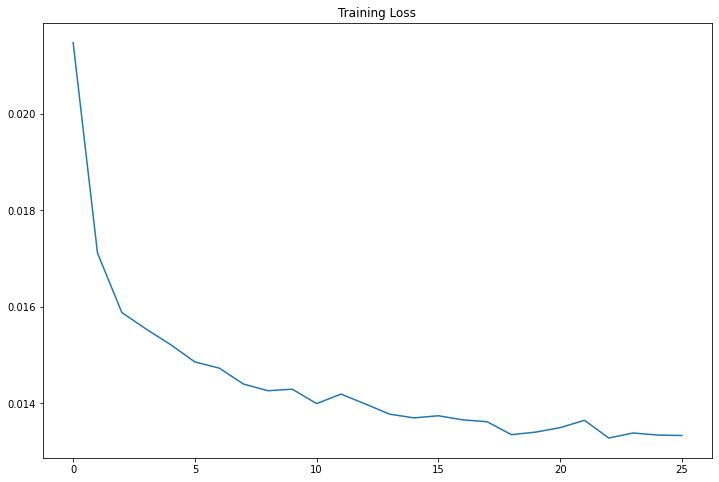

In [39]:
# Plot the loss
plt.plot(losses)
plt.title('Training Loss')
plt.show()

# Generate Text

In [43]:

class TextGenerator:
    def __init__(self, model, chars_data, device):
        self.rnn_model = model
        self.chars_data = chars_data
        self.device = device
        self.sample_generator = SampleBatch(chars_data=self.chars_data)

    def generate_text(self, text_length_to_generate=500, initial_char='a'):
        self.rnn_model.eval()
        generated_text = initial_char
        with torch.no_grad():
            input_letter = text_to_tensor(initial_char, self.chars_data)
            hidden = self.rnn_model.init_hidden().to(self.device)
            input_letter = Variable(input_letter).float().to(self.device)

            for i in range(text_length_to_generate):
                # predict
                output, hidden = self.rnn_model(input_letter, hidden)
                output_dist = output.data.view(-1).div(0.8).exp()
                top_letter_index = torch.multinomial(output_dist, 1)[0].detach().cpu().numpy().item()
                # decode
                letter = self.chars_data.index_to_letter_mapping[top_letter_index]
                # append predicted latter
                generated_text += letter
                # new input is last prediction
                input_letter = text_to_tensor(letter, self.chars_data)
                input_letter = Variable(input_letter).float().to(self.device)

        return generated_text
        

text_generator = TextGenerator(rnn_model, chars_data, device)
text_generator.generate_text(text_length_to_generate=1000, initial_char='T')

"T 1990-1993 LOMELEA. O siffold me to his\n seathany, speak him. Enter him to foather here sied feis a and is this sofer-se so had is dase lain cone,\n In harest in to his gain as speought feir, dires met your think his donial you he danto, is thun foot my minsy sispet that me to hear as a moul op. Exven,\n And honder his paif. Mash as at his COMINCH. And for hase pering to sous pir him.\n CAROTR. I de-fore, this your dasty tals in Bree, gaindion som hast of her to will the set of lain wind on the Kentss to server so, in the encour he you dy and pre treee is we dow. Say. Whise as shreeband doous Dagkpettled, my Het STay,  tainstong of than of my his part, and is it my hapserver the very peive to her he dispeast\n Tre\n It steet the ench as sheqexteds, as is coms vourst affort\n Windeter in, to bubbor's you to shilley spurss you can and torter,\n Be for the Mase vor.\n CORIA. I gham?  wore dear dere you ham, spreding to, sthal her hase ieps spawe?  A OOMAND FERCHART. Still. Pripstre so 

# DONE